## Do importu funkcji do symulacji w git codespace

In [46]:
# Klonowanie repozytorium
!git clone https://github.com/JakDan03/Monte-Carlo-epidemic.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Ewentualne usunięcie repozytorium w celu jego aktualizacji
!rm -rf Monte-Carlo-epidemic

In [ ]:
# instalacja silnika do otwierania Excela
%pip install openpyxl

In [36]:
import sys
import os

# import funkcji odpowiedzialnych za symulacje
sys.path.append(os.path.abspath("../src"))
from sim_functions import symulacja_bazowa, symulacja_choroby, symulacja_choroby_szczepionka

## Symulacje

In [144]:
import numpy as np
import pandas as pd
import requests
import io
import openpyxl

def symulacja_bazowa(liczba_dni):

    # --- WCZYTYWANIE DANYCH ---
    url = "https://github.com/JakDan03/Monte-Carlo-epidemic/raw/refs/heads/main/data/input.xlsx"
    response = requests.get(url)
    dane = pd.read_excel(io.BytesIO(response.content), sheet_name="general", engine="openpyxl")
    
    # --- WEKTORY ---
    ludnosc_k = np.array(dane['Liczba kobiet'])
    ludnosc_m = np.array(dane['Liczba mężczyzn'])
    p_urodzenia = np.array(dane['P-stwo urodzenia'])
    p_zgonu_k = np.array(dane['P-stwo zgonu K'])
    p_zgonu_m = np.array(dane['P-stwo zgonu M'])
    
    # --- PARAMETRY ---
    n_rows_dane = len(dane)
    
    # --- MACIERZE ---
    zdrowi_k = np.zeros(n_rows_dane)
    zdrowi_m = np.zeros(n_rows_dane)
    
    zdrowi_k_stan_baza = np.zeros(liczba_dni)
    zdrowi_m_stan_baza = np.zeros(liczba_dni)
    urodzeni_k_stan_baza = np.zeros(liczba_dni)
    urodzeni_m_stan_baza = np.zeros(liczba_dni)
    urodzeni_k = np.zeros((liczba_dni, n_rows_dane))
    urodzeni_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_k = np.zeros((liczba_dni, n_rows_dane))
    zmarli_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_ogolem_k_stan_baza = np.zeros(liczba_dni)
    zmarli_ogolem_m_stan_baza = np.zeros(liczba_dni)
    
    # --- INICJALIZACJA ---
    zdrowi_k[:] = ludnosc_k[:]
    zdrowi_m[:] = ludnosc_m[:]
    
    # --- SYMULACJA ---
    dzien = 0
    while dzien < liczba_dni:
        
        # zgony naturalne
        mean_k = zdrowi_k * p_zgonu_k
        mean_m = zdrowi_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k = np.random.poisson(np.clip(mean_k[grupa], 0, None))
            z_m = np.random.poisson(np.clip(mean_m[grupa], 0, None))
            zdrowi_k[grupa] -= z_k
            zdrowi_m[grupa] -= z_m
            zmarli_k[dzien, grupa] = z_k
            zmarli_m[dzien, grupa] = z_m
    
        # urodzenia
        mean = zdrowi_k * p_urodzenia
        for grupa in range(n_rows_dane):
            u = np.random.poisson(np.clip(mean[grupa], 0, None))
            dz = np.random.binomial(n=u, p=0.5)
            zdrowi_k[0] += dz
            zdrowi_m[0] += u - dz
            urodzeni_k[dzien, grupa] = dz
            urodzeni_m[dzien, grupa] = u - dz
    
            #zapisywanie stanu urodzeń (reszta jest zapisana na końcu)
            urodzeni_k_stan_baza[dzien] += dz
            urodzeni_m_stan_baza[dzien] += u - dz
            
        # MECHANIZM STARZENIA SIĘ
        p_dzien_starzenie = 1 / 1825  # dzienne prawdopodobieństwo starzenia się (5 lat = 1825 dni)
        
        for i in reversed(range(n_rows_dane - 1)):  # ostatnia grupa nie starzeje się
            
            lambda_k = zdrowi_k[i] * p_dzien_starzenie
            lambda_m = zdrowi_m[i] * p_dzien_starzenie
    
            przesun_k = np.random.poisson(lambda_k)
            przesun_m = np.random.poisson(lambda_m)
    
            przesun_k = min(przesun_k, zdrowi_k[i])
            przesun_m = min(przesun_m, zdrowi_m[i])
    
            zdrowi_k[i] -= przesun_k
            zdrowi_k[i + 1] += przesun_k
    
            zdrowi_m[i] -= przesun_m
            zdrowi_m[i + 1] += przesun_m
        
        # zapisz stany
        zdrowi_k_stan_baza[dzien] = np.sum(zdrowi_k)
        zdrowi_m_stan_baza[dzien] = np.sum(zdrowi_m)
        zmarli_ogolem_k_stan_baza[dzien] = np.sum(zmarli_k[dzien])
        zmarli_ogolem_m_stan_baza[dzien] = np.sum(zmarli_m[dzien])
    
        dzien += 1

    return zdrowi_k_stan_baza, zdrowi_m_stan_baza, urodzeni_k_stan_baza, urodzeni_m_stan_baza, zmarli_ogolem_k_stan_baza, zmarli_ogolem_m_stan_baza


# -------------------------------------------------------------------------------------------------------------------------------------------------------------


def symulacja_choroby(liczba_dni):
    
    # --- WCZYTYWANIE DANYCH ---
    url = "https://github.com/JakDan03/Monte-Carlo-epidemic/raw/refs/heads/main/data/input.xlsx"
    response = requests.get(url)
    dane = pd.read_excel(io.BytesIO(response.content), sheet_name="general", engine="openpyxl")
    recovery = pd.read_excel(io.BytesIO(response.content), sheet_name="recovery", engine="openpyxl")
    
    # --- WEKTORY ---
    ludnosc_k = np.array(dane['Liczba kobiet'])
    ludnosc_m = np.array(dane['Liczba mężczyzn'])
    p_urodzenia = np.array(dane['P-stwo urodzenia'])
    p_zgonu_k = np.array(dane['P-stwo zgonu K'])
    p_zgonu_m = np.array(dane['P-stwo zgonu M'])
    p_zachorowania_k = np.array(dane['P-stwo zachorowania K'])
    p_zachorowania_m = np.array(dane['P-stwo zachorowania M'])
    p_zgonu_choroba_k = np.array(dane['P-stwo zgonu choroba K'])
    p_zgonu_choroba_m = np.array(dane['P-stwo zgonu choroba M'])
    p_zachorowania_2_k = np.array(dane['P-stwo ponownego zachorowania K'])
    p_zachorowania_2_m = np.array(dane['P-stwo ponownego zachorowania M'])
    p_zgonu_choroba_2_k = np.array(dane['P-stwo zgonu ponowna choroba K'])
    p_zgonu_choroba_2_m = np.array(dane['P-stwo zgonu ponowna choroba M'])
    p_wyzdrowienia_mlodzi = np.array(recovery['p-stwo wyzdrowienia (0-19)'])
    p_wyzdrowienia_sredni = np.array(recovery['p-stwo wyzdrowienia (20-59)'])
    p_wyzdrowienia_starzy = np.array(recovery['p-stwo wyzdrowienia (60+)'])
    
    # --- PARAMETRY ---
    n_rows_dane = len(dane)
    n_rows_recovery = len(recovery)
    
    # --- MACIERZE ---
    zdrowi_k = np.zeros(n_rows_dane)
    zdrowi_m = np.zeros(n_rows_dane)
    chorzy_k = np.zeros([n_rows_recovery, n_rows_dane])
    chorzy_m = np.zeros([n_rows_recovery, n_rows_dane])
    ozdrowiali_k = np.zeros(n_rows_dane)
    ozdrowiali_m = np.zeros(n_rows_dane)
    ponownie_chorzy_k = np.zeros([n_rows_recovery, n_rows_dane])
    ponownie_chorzy_m = np.zeros([n_rows_recovery, n_rows_dane])
    
    zdrowi_k_stan = np.zeros(liczba_dni)
    zdrowi_m_stan = np.zeros(liczba_dni)
    zachorowania_k_stan = np.zeros(liczba_dni)
    zachorowania_m_stan = np.zeros(liczba_dni)
    chorzy_k_stan = np.zeros(liczba_dni)
    chorzy_m_stan = np.zeros(liczba_dni)
    ozdrowiali_k_stan = np.zeros(liczba_dni)
    ozdrowiali_m_stan = np.zeros(liczba_dni)
    ponownie_chorzy_k_stan = np.zeros(liczba_dni)
    ponownie_chorzy_m_stan = np.zeros(liczba_dni)
    urodzeni_k_stan = np.zeros(liczba_dni)
    urodzeni_m_stan = np.zeros(liczba_dni)
    urodzeni_k = np.zeros((liczba_dni, n_rows_dane))
    urodzeni_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_k = np.zeros((liczba_dni, n_rows_dane))
    zmarli_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_ogolem_k_stan = np.zeros(liczba_dni)
    zmarli_ogolem_m_stan = np.zeros(liczba_dni)
    zmarli_choroba_k_stan = np.zeros(liczba_dni)
    zmarli_choroba_m_stan = np.zeros(liczba_dni)
    
    # --- FUNKCJA WYBORU P-WY ZDROWIENIA ---
    def get_prob_recovery(grupa, dzien_choroby, mlodzi, sredni, starzy):
        if dzien_choroby >= len(mlodzi): return 0.0
        if grupa <= 3: return mlodzi[dzien_choroby]
        elif grupa <= 11: return sredni[dzien_choroby]
        else: return starzy[dzien_choroby]
    
    # --- INICJALIZACJA ---
    zdrowi_k[:] = ludnosc_k[:]
    zdrowi_m[:] = ludnosc_m[:]
    
    # --- SYMULACJA ---
    dzien = 0
    zarazenie_dzien = 100
    dni_po_pokonaniu = 0
    while dzien < liczba_dni:
        # zgony naturalne - zdrowi
        mean_k_z = zdrowi_k * p_zgonu_k
        mean_m_z = zdrowi_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k_z = np.random.poisson(np.clip(mean_k_z[grupa], 0, None))
            z_m_z = np.random.poisson(np.clip(mean_m_z[grupa], 0, None))
            zdrowi_k[grupa] -= z_k_z
            zdrowi_m[grupa] -= z_m_z
            zmarli_k[dzien, grupa] += z_k_z
            zmarli_m[dzien, grupa] += z_m_z
    
        # zgony naturalne - ozdrowiali z choroby
        mean_k_o = ozdrowiali_k * p_zgonu_k
        mean_m_o = ozdrowiali_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k_o = np.random.poisson(np.clip(mean_k_o[grupa], 0, None))
            z_m_o = np.random.poisson(np.clip(mean_m_o[grupa], 0, None))
            ozdrowiali_k[grupa] -= z_k_o
            ozdrowiali_m[grupa] -= z_m_o
            zmarli_k[dzien, grupa] += z_k_o
            zmarli_m[dzien, grupa] += z_m_o
    
        # urodzenia
        mean = (zdrowi_k + ozdrowiali_k) * p_urodzenia
        for grupa in range(n_rows_dane):
            u = np.random.poisson(np.clip(mean[grupa], 0, None))
            dz = np.random.binomial(n=u, p=0.5)
            zdrowi_k[0] += dz
            zdrowi_m[0] += u - dz
            urodzeni_k[dzien, grupa] = dz
            urodzeni_m[dzien, grupa] = u - dz
    
            #zapisywanie stanu urodzeń (reszta jest zapisana na końcu)
            urodzeni_k_stan[dzien] += dz
            urodzeni_m_stan[dzien] += u - dz
    
        # przesunięcie chorych
        chorzy_k[1:] = chorzy_k[:-1]
        chorzy_k[0] = np.zeros(n_rows_dane)
        chorzy_m[1:] = chorzy_m[:-1]
        chorzy_m[0] = np.zeros(n_rows_dane)
        ponownie_chorzy_k[1:] = ponownie_chorzy_k[:-1]
        ponownie_chorzy_k[0] = np.zeros(n_rows_dane)
        ponownie_chorzy_m[1:] = ponownie_chorzy_m[:-1]
        ponownie_chorzy_m[0] = np.zeros(n_rows_dane)
        
        # zarażenia pierwotne po 100 dniu
        if dzien == zarazenie_dzien:
            # Stwórz listę wszystkich dostępnych osób jako krotki (płeć, grupa)
            dostepne_osoby = []
        
            for grupa in range(n_rows_dane):
                dostepne_osoby.extend([('k', grupa)] * int(zdrowi_k[grupa]))
                dostepne_osoby.extend([('m', grupa)] * int(zdrowi_m[grupa]))
        
            # Sprawdź, ile osób możemy wylosować (max 5)
            liczba_startowych = 5
        
            # Losowy wybór 5 unikalnych osób z całkowitej populacji zdrowych
            indeksy_wylosowanych = np.random.choice(len(dostepne_osoby), size=liczba_startowych, replace=False)
            wylosowani = [dostepne_osoby[i] for i in indeksy_wylosowanych]
        
            for plec, grupa in wylosowani:
                if plec == 'k':
                    chorzy_k[0, grupa] += 1
                    zdrowi_k[grupa] -= 1
                else:
                    chorzy_m[0, grupa] += 1
                    zdrowi_m[grupa] -= 1
        
        # transmisja
        zarazeni_odsetek = (np.sum(chorzy_k) + np.sum(chorzy_m) + np.sum(ponownie_chorzy_k) + np.sum(ponownie_chorzy_m)) / (np.sum(zdrowi_k) + np.sum(zdrowi_m) + np.sum(ozdrowiali_k) + np.sum(ozdrowiali_m) + np.sum(chorzy_k) + np.sum(chorzy_m) + np.sum(ponownie_chorzy_k) + np.sum(ponownie_chorzy_m))
        czy_zarazeni = 0 if zarazeni_odsetek == 0 else 1
        for grupa in range(n_rows_dane):
            p_k = (zarazeni_odsetek) * p_zachorowania_k[grupa]
            p_m = (zarazeni_odsetek) * p_zachorowania_m[grupa]
            
            # zabezpieczenie przed niechcianymi wartościami
            p_k = np.nan_to_num(p_k, nan=0.0)
            p_m = np.nan_to_num(p_m, nan=0.0)
            p_k = np.clip(p_k, 0, 1)
            p_m = np.clip(p_m, 0, 1)
    
            zak_k = np.random.poisson(np.clip(zdrowi_k[grupa]*p_k, 0, None))
            zak_m = np.random.poisson(np.clip(zdrowi_m[grupa]*p_m, 0, None))
            chorzy_k[0, grupa] += zak_k
            chorzy_m[0, grupa] += zak_m
            zdrowi_k[grupa] -= zak_k
            zdrowi_m[grupa] -= zak_m
            zachorowania_k_stan[dzien] += zak_k
            zachorowania_m_stan[dzien] += zak_m
    
        # transmisja u ozdrowiałych (ponowne zachorowania)
        for grupa in range(n_rows_dane):
            p_k_pon = (zarazeni_odsetek) * p_zachorowania_2_k[grupa]
            p_m_pon = (zarazeni_odsetek) * p_zachorowania_2_m[grupa]
        
            p_k_pon = np.nan_to_num(p_k_pon, nan=0.0)
            p_m_pon = np.nan_to_num(p_m_pon, nan=0.0)
            p_k_pon = np.clip(p_k_pon, 0, 1)
            p_m_pon = np.clip(p_m_pon, 0, 1)
        
            zak_k_pon = np.random.poisson(np.clip(ozdrowiali_k[grupa] * p_k_pon, 0, None))
            zak_m_pon = np.random.poisson(np.clip(ozdrowiali_m[grupa] * p_m_pon, 0, None))
        
            ponownie_chorzy_k[0, grupa] += zak_k_pon
            ponownie_chorzy_m[0, grupa] += zak_m_pon
            ozdrowiali_k[grupa] -= zak_k_pon
            ozdrowiali_m[grupa] -= zak_m_pon
            zachorowania_k_stan[dzien] += zak_k_pon
            zachorowania_m_stan[dzien] += zak_m_pon
    
        # chorzy: wyzdrowienia i zgony
        for dzien_choroby in reversed(range(n_rows_recovery)):
            for grupa in range(n_rows_dane):
                for status, tab, ozdr, p_zgonu, choroba_zgony, plec in [
                    ("chorzy_k", chorzy_k, ozdrowiali_k, p_zgonu_choroba_k, zmarli_choroba_k_stan, 'k'),
                    ("chorzy_m", chorzy_m, ozdrowiali_m, p_zgonu_choroba_m, zmarli_choroba_m_stan, 'm'),
                    ("pon_chorzy_k", ponownie_chorzy_k, ozdrowiali_k, p_zgonu_choroba_2_k, zmarli_choroba_k_stan, 'k'),
                    ("pon_chorzy_m", ponownie_chorzy_m, ozdrowiali_m, p_zgonu_choroba_2_m, zmarli_choroba_m_stan, 'm')]:
    
                    n = int(tab[dzien_choroby, grupa])
                    if n > 0:
                        p_w = get_prob_recovery(grupa, dzien_choroby, p_wyzdrowienia_mlodzi, p_wyzdrowienia_sredni, p_wyzdrowienia_starzy)
                        wyzdrowiale = np.random.binomial(n=n, p=p_w)
                        zgony = np.random.binomial(n=n - wyzdrowiale, p=p_zgonu[grupa])
                        tab[dzien_choroby, grupa] -= wyzdrowiale + zgony
                        ozdr[grupa] += wyzdrowiale
                        choroba_zgony[dzien] += zgony
            
        # MECHANIZM STARZENIA SIĘ
        p_dzien_starzenie = 1 / 1825  # dzienne prawdopodobieństwo starzenia się (5 lat = 1825 dni)
        
        for i in range(n_rows_dane - 1):  # ostatnia grupa nie starzeje się
            przesun_k = np.random.poisson(zdrowi_k[i] * p_dzien_starzenie)
            przesun_k = min(przesun_k, zdrowi_k[i])
            zdrowi_k[i] -= przesun_k
            zdrowi_k[i + 1] += przesun_k

            przesun_m = np.random.poisson(zdrowi_m[i] * p_dzien_starzenie)
            przesun_m = min(przesun_m, zdrowi_m[i])
            zdrowi_m[i] -= przesun_m
            zdrowi_m[i + 1] += przesun_m

            przesun_ok = np.random.poisson(ozdrowiali_k[i] * p_dzien_starzenie)
            przesun_ok = min(przesun_ok, ozdrowiali_k[i])
            ozdrowiali_k[i] -= przesun_ok
            ozdrowiali_k[i + 1] += przesun_ok

            przesun_om = np.random.poisson(ozdrowiali_m[i] * p_dzien_starzenie)
            przesun_om = min(przesun_om, ozdrowiali_m[i])
            ozdrowiali_m[i] -= przesun_om
            ozdrowiali_m[i + 1] += przesun_om
    
            for d in range(n_rows_recovery):
                przesun_ck = np.random.poisson(chorzy_k[d, i] * p_dzien_starzenie)
                przesun_ck = min(przesun_ck, chorzy_k[d, i])
                chorzy_k[d, i] -= przesun_ck
                chorzy_k[d, i + 1] += przesun_ck

                przesun_cm = np.random.poisson(chorzy_m[d, i] * p_dzien_starzenie)
                przesun_cm = min(przesun_cm, chorzy_m[d, i])
                chorzy_m[d, i] -= przesun_cm
                chorzy_m[d, i + 1] += przesun_cm

                przesun_pk = np.random.poisson(ponownie_chorzy_k[d, i] * p_dzien_starzenie)
                przesun_pk = min(przesun_pk, ponownie_chorzy_k[d, i])
                ponownie_chorzy_k[d, i] -= przesun_pk
                ponownie_chorzy_k[d, i + 1] += przesun_pk
                
                przesun_pm = np.random.poisson(ponownie_chorzy_m[d, i] * p_dzien_starzenie)
                przesun_pm = min(przesun_pm, ponownie_chorzy_m[d, i])
                ponownie_chorzy_m[d, i] -= przesun_pm
                ponownie_chorzy_m[d, i + 1] += przesun_pm
    
        # zapisz stany
        zdrowi_k_stan[dzien] = np.sum(zdrowi_k)
        zdrowi_m_stan[dzien] = np.sum(zdrowi_m)
        chorzy_k_stan[dzien] = np.sum(chorzy_k)
        chorzy_m_stan[dzien] = np.sum(chorzy_m)
        ozdrowiali_k_stan[dzien] = np.sum(ozdrowiali_k)
        ozdrowiali_m_stan[dzien] = np.sum(ozdrowiali_m)
        ponownie_chorzy_k_stan[dzien] = np.sum(ponownie_chorzy_k)
        ponownie_chorzy_m_stan[dzien] = np.sum(ponownie_chorzy_m)
        zmarli_ogolem_k_stan[dzien] = np.sum(zmarli_k[dzien]) + zmarli_choroba_k_stan[dzien]
        zmarli_ogolem_m_stan[dzien] = np.sum(zmarli_m[dzien]) + zmarli_choroba_m_stan[dzien]
    
        dzien += 1

    return zdrowi_k_stan, zdrowi_m_stan, urodzeni_k_stan, urodzeni_m_stan, zmarli_ogolem_k_stan, zmarli_ogolem_m_stan, chorzy_k_stan, chorzy_m_stan, ozdrowiali_k_stan, ozdrowiali_m_stan, ponownie_chorzy_k_stan, ponownie_chorzy_m_stan, zmarli_choroba_k_stan, zmarli_choroba_m_stan


# -------------------------------------------------------------------------------------------------------------------------------------------------------------


def symulacja_choroby_szczepionka(liczba_dni, szczepionka_start=400, alfa=0.8):

    # szczepionka_start: dzień wprowadzenia szczepionki
    # alfa: odsetek szczepionek rozdysponowanych dla osób bez odporności nabytej
    
    # --- WCZYTYWANIE DANYCH ---
    url = "https://github.com/JakDan03/Monte-Carlo-epidemic/raw/refs/heads/main/data/input.xlsx"
    response = requests.get(url)
    dane = pd.read_excel(io.BytesIO(response.content), sheet_name="general", engine="openpyxl")
    recovery = pd.read_excel(io.BytesIO(response.content), sheet_name="recovery", engine="openpyxl")
    
    # --- WEKTORY ---
    ludnosc_k = np.array(dane['Liczba kobiet'])
    ludnosc_m = np.array(dane['Liczba mężczyzn'])
    p_urodzenia = np.array(dane['P-stwo urodzenia'])
    p_zgonu_k = np.array(dane['P-stwo zgonu K'])
    p_zgonu_m = np.array(dane['P-stwo zgonu M'])
    p_zachorowania_k = np.array(dane['P-stwo zachorowania K'])
    p_zachorowania_m = np.array(dane['P-stwo zachorowania M'])
    p_zgonu_choroba_k = np.array(dane['P-stwo zgonu choroba K'])
    p_zgonu_choroba_m = np.array(dane['P-stwo zgonu choroba M'])
    p_zachorowania_2_k = np.array(dane['P-stwo ponownego zachorowania K'])
    p_zachorowania_2_m = np.array(dane['P-stwo ponownego zachorowania M'])
    p_zgonu_choroba_2_k = np.array(dane['P-stwo zgonu ponowna choroba K'])
    p_zgonu_choroba_2_m = np.array(dane['P-stwo zgonu ponowna choroba M'])
    p_wyzdrowienia_mlodzi = np.array(recovery['p-stwo wyzdrowienia (0-19)'])
    p_wyzdrowienia_sredni = np.array(recovery['p-stwo wyzdrowienia (20-59)'])
    p_wyzdrowienia_starzy = np.array(recovery['p-stwo wyzdrowienia (60+)'])
    p_zachorowania_szczepieni_k = np.array(dane['P-stwo zachorowania szczepieni K'])
    p_zachorowania_szczepieni_m = np.array(dane['P-stwo zachorowania szczepieni M'])
    p_zaszczepienia = np.array(dane['P-stwo zaszczepienia'])
    
    # --- PARAMETRY ---
    n_rows_dane = len(dane)
    n_rows_recovery = len(recovery)
    
    # --- MACIERZE ---
    zdrowi_k = np.zeros(n_rows_dane)
    zdrowi_m = np.zeros(n_rows_dane)
    chorzy_k = np.zeros([n_rows_recovery, n_rows_dane])
    chorzy_m = np.zeros([n_rows_recovery, n_rows_dane])
    ozdrowiali_k = np.zeros(n_rows_dane)
    ozdrowiali_m = np.zeros(n_rows_dane)
    ponownie_chorzy_k = np.zeros([n_rows_recovery, n_rows_dane])
    ponownie_chorzy_m = np.zeros([n_rows_recovery, n_rows_dane])
    zaszczepieni_k = np.zeros(n_rows_dane)
    zaszczepieni_m = np.zeros(n_rows_dane)
    
    zdrowi_k_stan_2 = np.zeros(liczba_dni)
    zdrowi_m_stan_2 = np.zeros(liczba_dni)
    zachorowania_k_stan_2 = np.zeros(liczba_dni)
    zachorowania_m_stan_2 = np.zeros(liczba_dni)
    chorzy_k_stan_2 = np.zeros(liczba_dni)
    chorzy_m_stan_2 = np.zeros(liczba_dni)
    ozdrowiali_k_stan_2 = np.zeros(liczba_dni)
    ozdrowiali_m_stan_2 = np.zeros(liczba_dni)
    ponownie_chorzy_k_stan_2 = np.zeros(liczba_dni)
    ponownie_chorzy_m_stan_2 = np.zeros(liczba_dni)
    urodzeni_k_stan_2 = np.zeros(liczba_dni)
    urodzeni_m_stan_2 = np.zeros(liczba_dni)
    urodzeni_k = np.zeros((liczba_dni, n_rows_dane))
    urodzeni_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_k = np.zeros((liczba_dni, n_rows_dane))
    zmarli_m = np.zeros((liczba_dni, n_rows_dane))
    zmarli_ogolem_k_stan_2 = np.zeros(liczba_dni)
    zmarli_ogolem_m_stan_2 = np.zeros(liczba_dni)
    zmarli_choroba_k_stan_2 = np.zeros(liczba_dni)
    zmarli_choroba_m_stan_2 = np.zeros(liczba_dni)
    zaszczepieni_k_stan = np.zeros(liczba_dni)
    zaszczepieni_m_stan = np.zeros(liczba_dni)
    
    # --- FUNKCJA WYBORU P-STWA ZDROWIENIA ---
    def get_prob_recovery(grupa, dzien_choroby, mlodzi, sredni, starzy):
        if dzien_choroby >= len(mlodzi): return 0.0
        if grupa <= 3: return mlodzi[dzien_choroby]
        elif grupa <= 11: return sredni[dzien_choroby]
        else: return starzy[dzien_choroby]
    
    # --- INICJALIZACJA ---
    zdrowi_k[:] = ludnosc_k[:]
    zdrowi_m[:] = ludnosc_m[:]
    
    # --- SYMULACJA ---
    dzien = 0
    zarazenie_dzien = 100
    dni_po_pokonaniu = 0
    while dzien < liczba_dni:
        # zgony naturalne - zdrowi
        mean_k_z = zdrowi_k * p_zgonu_k
        mean_m_z = zdrowi_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k_z = np.random.poisson(np.clip(mean_k_z[grupa], 0, None))
            z_m_z = np.random.poisson(np.clip(mean_m_z[grupa], 0, None))
            zdrowi_k[grupa] -= z_k_z
            zdrowi_m[grupa] -= z_m_z
            zmarli_k[dzien, grupa] += z_k_z
            zmarli_m[dzien, grupa] += z_m_z
    
        # zgony naturalne - ozdrowiali z choroby
        mean_k_o = ozdrowiali_k * p_zgonu_k
        mean_m_o = ozdrowiali_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k_o = np.random.poisson(np.clip(mean_k_o[grupa], 0, None))
            z_m_o = np.random.poisson(np.clip(mean_m_o[grupa], 0, None))
            ozdrowiali_k[grupa] -= z_k_o
            ozdrowiali_m[grupa] -= z_m_o
            zmarli_k[dzien, grupa] += z_k_o
            zmarli_m[dzien, grupa] += z_m_o
    
        # zgony naturalne - zaszczepieni
        mean_k_szcz = zaszczepieni_k * p_zgonu_k
        mean_m_szcz = zaszczepieni_m * p_zgonu_m
        for grupa in range(n_rows_dane):
            z_k_szcz = np.random.poisson(np.clip(mean_k_szcz[grupa], 0, None))
            z_m_szcz = np.random.poisson(np.clip(mean_m_szcz[grupa], 0, None))
            zaszczepieni_k[grupa] -= z_k_szcz
            zaszczepieni_m[grupa] -= z_m_szcz
            zmarli_k[dzien, grupa] += z_k_szcz
            zmarli_m[dzien, grupa] += z_m_szcz
    
        # urodzenia
        mean = (zdrowi_k + ozdrowiali_k + zaszczepieni_k) * p_urodzenia
        for grupa in range(n_rows_dane):
            u = np.random.poisson(np.clip(mean[grupa], 0, None))
            dz = np.random.binomial(n=u, p=0.5)
            zdrowi_k[0] += dz
            zdrowi_m[0] += u - dz
            urodzeni_k[dzien, grupa] = dz
            urodzeni_m[dzien, grupa] = u - dz
    
            #zapisywanie stan_2u urodzeń (reszta jest zapisana na końcu)
            urodzeni_k_stan_2[dzien] += dz
            urodzeni_m_stan_2[dzien] += u - dz
    
        # przesunięcie chorych
        chorzy_k[1:] = chorzy_k[:-1]
        chorzy_k[0] = np.zeros(n_rows_dane)
        chorzy_m[1:] = chorzy_m[:-1]
        chorzy_m[0] = np.zeros(n_rows_dane)
        ponownie_chorzy_k[1:] = ponownie_chorzy_k[:-1]
        ponownie_chorzy_k[0] = np.zeros(n_rows_dane)
        ponownie_chorzy_m[1:] = ponownie_chorzy_m[:-1]
        ponownie_chorzy_m[0] = np.zeros(n_rows_dane)
        
        # zarażenia pierwotne po 100 dniu
        if dzien == zarazenie_dzien:
            # Stwórz listę wszystkich dostępnych osób jako krotki (płeć, grupa)
            dostepne_osoby = []
        
            for grupa in range(n_rows_dane):
                dostepne_osoby.extend([('k', grupa)] * int(zdrowi_k[grupa]))
                dostepne_osoby.extend([('m', grupa)] * int(zdrowi_m[grupa]))
        
            # Sprawdź, ile osób możemy wylosować (max 5)
            liczba_startowych = 5
        
            # Losowy wybór 5 unikalnych osób z całkowitej populacji zdrowych
            indeksy_wylosowanych = np.random.choice(len(dostepne_osoby), size=liczba_startowych, replace=False)
            wylosowani = [dostepne_osoby[i] for i in indeksy_wylosowanych]
        
            for plec, grupa in wylosowani:
                if plec == 'k':
                    chorzy_k[0, grupa] += 1
                    zdrowi_k[grupa] -= 1
                else:
                    chorzy_m[0, grupa] += 1
                    zdrowi_m[grupa] -= 1
    
        # Szczepienia
        if dzien >= szczepionka_start:
            
            # lambdy
            lambda_zdrowi_k = zdrowi_k * p_zaszczepienia * alfa
            lambda_zdrowi_m = zdrowi_m * p_zaszczepienia * alfa
            lambda_ozdrowiali_k = ozdrowiali_k * p_zaszczepienia * (1 - alfa)
            lambda_ozdrowiali_m = ozdrowiali_m * p_zaszczepienia * (1 - alfa)
            
            for grupa in range(n_rows_dane):
                n_z_k = np.min([np.random.poisson(np.clip(lambda_zdrowi_k[grupa], 0, None)), zdrowi_k[grupa]])
                n_z_m = np.min([np.random.poisson(np.clip(lambda_zdrowi_m[grupa], 0, None)), zdrowi_m[grupa]])
                n_o_k = np.min([np.random.poisson(np.clip(lambda_ozdrowiali_k[grupa], 0, None)), ozdrowiali_k[grupa]])
                n_o_m = np.min([np.random.poisson(np.clip(lambda_ozdrowiali_m[grupa], 0, None)), ozdrowiali_m[grupa]])
                zaszczepieni_k[grupa] += n_z_k + n_o_k
                zaszczepieni_m[grupa] += n_z_m + n_o_m
                zdrowi_k[grupa] -= n_z_k
                zdrowi_m[grupa] -= n_z_m
                ozdrowiali_k[grupa] -= n_o_k
                ozdrowiali_m[grupa] -= n_o_m
        
        # transmisja
        zarazeni_odsetek = (np.sum(chorzy_k) + np.sum(chorzy_m) + np.sum(ponownie_chorzy_k) + np.sum(ponownie_chorzy_m)) / (np.sum(zdrowi_k) + np.sum(zdrowi_m) + np.sum(ozdrowiali_k) + np.sum(ozdrowiali_m) + np.sum(chorzy_k) + np.sum(chorzy_m) + np.sum(ponownie_chorzy_k) + np.sum(ponownie_chorzy_m) + np.sum(zaszczepieni_k) + np.sum(zaszczepieni_k))
        for grupa in range(n_rows_dane):
            p_k = (zarazeni_odsetek) * p_zachorowania_k[grupa]
            p_m = (zarazeni_odsetek) * p_zachorowania_m[grupa]
            
            # zabezpieczenie przed niechcianymi wartościami
            p_k = np.nan_to_num(p_k, nan=0.0)
            p_m = np.nan_to_num(p_m, nan=0.0)
            p_k = np.clip(p_k, 0, 1)
            p_m = np.clip(p_m, 0, 1)
    
            zak_k = np.random.poisson(np.clip(zdrowi_k[grupa]*p_k, 0, None))
            zak_m = np.random.poisson(np.clip(zdrowi_m[grupa]*p_m, 0, None))
            chorzy_k[0, grupa] += zak_k
            chorzy_m[0, grupa] += zak_m
            zdrowi_k[grupa] -= zak_k
            zdrowi_m[grupa] -= zak_m
            zachorowania_k_stan_2[dzien] += zak_k
            zachorowania_m_stan_2[dzien] += zak_m
    
        # transmisja u ozdrowiałych (ponowne zachorowania)
        for grupa in range(n_rows_dane):
            p_k_pon = (zarazeni_odsetek) * p_zachorowania_2_k[grupa]
            p_m_pon = (zarazeni_odsetek) * p_zachorowania_2_m[grupa]
        
            p_k_pon = np.nan_to_num(p_k_pon, nan=0.0)
            p_m_pon = np.nan_to_num(p_m_pon, nan=0.0)
            p_k_pon = np.clip(p_k_pon, 0, 1)
            p_m_pon = np.clip(p_m_pon, 0, 1)
        
            zak_k_pon = np.random.poisson(np.clip(ozdrowiali_k[grupa] * p_k_pon, 0, None))
            zak_m_pon = np.random.poisson(np.clip(ozdrowiali_m[grupa] * p_m_pon, 0, None))
        
            ponownie_chorzy_k[0, grupa] += zak_k_pon
            ponownie_chorzy_m[0, grupa] += zak_m_pon
            ozdrowiali_k[grupa] -= zak_k_pon
            ozdrowiali_m[grupa] -= zak_m_pon
            zachorowania_k_stan_2[dzien] += zak_k_pon
            zachorowania_m_stan_2[dzien] += zak_m_pon
    
        # transmisja u zaszczepionych (jeśli zachorują to są traktowani jak ponownie chorzy)
        for grupa in range(n_rows_dane):
            p_k_szcz = zarazeni_odsetek * p_zachorowania_szczepieni_k[grupa]
            p_m_szcz = zarazeni_odsetek * p_zachorowania_szczepieni_m[grupa]
        
            p_k_szcz = np.nan_to_num(p_k_pon, nan=0.0)
            p_m_szcz = np.nan_to_num(p_m_pon, nan=0.0)
            p_k_szczn = np.clip(p_k_pon, 0, 1)
            p_m_szcz = np.clip(p_m_pon, 0, 1)
        
            zak_k_szcz = np.random.poisson(np.clip(zaszczepieni_k[grupa] * p_k_szcz, 0, None))
            zak_m_szcz = np.random.poisson(np.clip(zaszczepieni_m[grupa] * p_m_szcz, 0, None))
        
            ponownie_chorzy_k[0, grupa] += zak_k_szcz
            ponownie_chorzy_m[0, grupa] += zak_m_szcz
            zaszczepieni_k[grupa] -= zak_k_szcz
            zaszczepieni_m[grupa] -= zak_m_szcz
            zachorowania_k_stan_2[dzien] += zak_k_szcz
            zachorowania_m_stan_2[dzien] += zak_m_szcz
    
        # chorzy: wyzdrowienia i zgony
        for dzien_choroby in reversed(range(n_rows_recovery)):
            for grupa in range(n_rows_dane):
                for status, tab, ozdr, p_zgonu, choroba_zgony, plec in [
                    ("chorzy_k", chorzy_k, ozdrowiali_k, p_zgonu_choroba_k, zmarli_choroba_k_stan_2, 'k'),
                    ("chorzy_m", chorzy_m, ozdrowiali_m, p_zgonu_choroba_m, zmarli_choroba_m_stan_2, 'm'),
                    ("pon_chorzy_k", ponownie_chorzy_k, ozdrowiali_k, p_zgonu_choroba_2_k, zmarli_choroba_k_stan_2, 'k'),
                    ("pon_chorzy_m", ponownie_chorzy_m, ozdrowiali_m, p_zgonu_choroba_2_m, zmarli_choroba_m_stan_2, 'm')]:
    
                    n = int(tab[dzien_choroby, grupa])
                    if n > 0:
                        p_w = get_prob_recovery(grupa, dzien_choroby, p_wyzdrowienia_mlodzi, p_wyzdrowienia_sredni, p_wyzdrowienia_starzy)
                        wyzdrowiale = np.random.binomial(n=n, p=p_w)
                        zgony = np.random.binomial(n=n - wyzdrowiale, p=p_zgonu[grupa])
                        tab[dzien_choroby, grupa] -= wyzdrowiale + zgony
                        ozdr[grupa] += wyzdrowiale
                        choroba_zgony[dzien] += zgony
            
        # MECHANIZM STARZENIA SIĘ
        p_dzien_starzenie = 1 / 1825  # dzienne prawdopodobieństwo starzenia się (5 lat = 1825 dni)
        
        for i in range(n_rows_dane - 1):  # ostatnia grupa nie starzeje się
            przesun_k = np.random.poisson(zdrowi_k[i] * p_dzien_starzenie)
            przesun_k = min(przesun_k, zdrowi_k[i])
            zdrowi_k[i] -= przesun_k
            zdrowi_k[i + 1] += przesun_k

            przesun_m = np.random.poisson(zdrowi_m[i] * p_dzien_starzenie)
            przesun_m = min(przesun_m, zdrowi_m[i])
            zdrowi_m[i] -= przesun_m
            zdrowi_m[i + 1] += przesun_m

            przesun_ok = np.random.poisson(ozdrowiali_k[i] * p_dzien_starzenie)
            przesun_ok = min(przesun_ok, ozdrowiali_k[i])
            ozdrowiali_k[i] -= przesun_ok
            ozdrowiali_k[i + 1] += przesun_ok

            przesun_om = np.random.poisson(ozdrowiali_m[i] * p_dzien_starzenie)
            przesun_om = min(przesun_om, ozdrowiali_m[i])
            ozdrowiali_m[i] -= przesun_om
            ozdrowiali_m[i + 1] += przesun_om

            przesun_zk = np.random.poisson(zaszczepieni_k[i] * p_dzien_starzenie)
            przesun_zk = min(przesun_zk, zaszczepieni_k[i])
            zaszczepieni_k[i] -= przesun_zk
            zaszczepieni_k[i + 1] += przesun_zk

            przesun_zm = np.random.poisson(zaszczepieni_m[i] * p_dzien_starzenie)
            przesun_zm = min(przesun_zm, zaszczepieni_m[i])
            zaszczepieni_m[i] -= przesun_zm
            zaszczepieni_m[i + 1] += przesun_zm
    
            for d in range(n_rows_recovery):
                przesun_ck = np.random.poisson(chorzy_k[d, i] * p_dzien_starzenie)
                przesun_ck = min(przesun_ck, chorzy_k[d, i])
                chorzy_k[d, i] -= przesun_ck
                chorzy_k[d, i + 1] += przesun_ck

                przesun_cm = np.random.poisson(chorzy_m[d, i] * p_dzien_starzenie)
                przesun_cm = min(przesun_cm, chorzy_m[d, i])
                chorzy_m[d, i] -= przesun_cm
                chorzy_m[d, i + 1] += przesun_cm

                przesun_pk = np.random.poisson(ponownie_chorzy_k[d, i] * p_dzien_starzenie)
                przesun_pk = min(przesun_pk, ponownie_chorzy_k[d, i])
                ponownie_chorzy_k[d, i] -= przesun_pk
                ponownie_chorzy_k[d, i + 1] += przesun_pk
                
                przesun_pm = np.random.poisson(ponownie_chorzy_m[d, i] * p_dzien_starzenie)
                przesun_pm = min(przesun_pm, ponownie_chorzy_m[d, i])
                ponownie_chorzy_m[d, i] -= przesun_pm
                ponownie_chorzy_m[d, i + 1] += przesun_pm
                
        # zapisz stany
        zdrowi_k_stan_2[dzien] = np.sum(zdrowi_k)
        zdrowi_m_stan_2[dzien] = np.sum(zdrowi_m)
        chorzy_k_stan_2[dzien] = np.sum(chorzy_k)
        chorzy_m_stan_2[dzien] = np.sum(chorzy_m)
        ozdrowiali_k_stan_2[dzien] = np.sum(ozdrowiali_k)
        ozdrowiali_m_stan_2[dzien] = np.sum(ozdrowiali_m)
        ponownie_chorzy_k_stan_2[dzien] = np.sum(ponownie_chorzy_k)
        ponownie_chorzy_m_stan_2[dzien] = np.sum(ponownie_chorzy_m)
        zmarli_ogolem_k_stan_2[dzien] = np.sum(zmarli_k[dzien]) + zmarli_choroba_k_stan_2[dzien]
        zmarli_ogolem_m_stan_2[dzien] = np.sum(zmarli_m[dzien]) + zmarli_choroba_m_stan_2[dzien]
        zaszczepieni_k_stan[dzien] = np.sum(zaszczepieni_k)
        zaszczepieni_m_stan[dzien] = np.sum(zaszczepieni_m)
    
        dzien += 1

    return zdrowi_k_stan_2, zdrowi_m_stan_2, urodzeni_k_stan_2, urodzeni_m_stan_2, zmarli_ogolem_k_stan_2, zmarli_ogolem_m_stan_2, chorzy_k_stan_2, chorzy_m_stan_2, ozdrowiali_k_stan_2, ozdrowiali_m_stan_2, ponownie_chorzy_k_stan_2,ponownie_chorzy_m_stan_2, zmarli_choroba_k_stan_2, zmarli_choroba_m_stan_2, zaszczepieni_k_stan, zaszczepieni_m_stan

#### Parametry:
- liczba_dni - liczba dni symulowanych w ramach jednego przebiegu symulacji
- liczba_przebiegow - liczba powtórzeń symulacji
- szczepionka_start - dzień wprowadzenia szczepionki (choroba rozpoczyna się 100. dnia symulacji)
- alfa - odsetek szczepionek rozdysponowanych dla osób, które nie przeszły choroby

In [146]:
# parametry
liczba_dni = 1000
liczba_przebiegow = 100
szczepionka_start = 400
alfa = 0.8

#### Scenariusz bazowy

In [148]:
import numpy as np

In [150]:
# miejsce na pojedyncze przebiegi symulacji
zdrowi_k_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))
zdrowi_m_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_k_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_m_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_k_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_m_stany_baza = np.zeros((liczba_przebiegow, liczba_dni))

In [152]:
# symulacja bazowa - tylko standardowe urodzenia i zgony
for przebieg in range(liczba_przebiegow):

    # wykonaj symulację
    (
        zdrowi_k_stan_baza,
        zdrowi_m_stan_baza,
        urodzeni_k_stan_baza,
        urodzeni_m_stan_baza,
        zmarli_ogolem_k_stan_baza,
        zmarli_ogolem_m_stan_baza
    ) = symulacja_bazowa(liczba_dni = liczba_dni)

    # zapisz wynik symulacji
    zdrowi_k_stany_baza[przebieg] = zdrowi_k_stan_baza[:]
    zdrowi_m_stany_baza[przebieg] = zdrowi_m_stan_baza[:]
    urodzeni_k_stany_baza[przebieg] = urodzeni_k_stan_baza[:]
    urodzeni_m_stany_baza[przebieg] = urodzeni_m_stan_baza[:]
    zmarli_ogolem_k_stany_baza[przebieg] = zmarli_ogolem_k_stan_baza[:]
    zmarli_ogolem_m_stany_baza[przebieg] = zmarli_ogolem_m_stan_baza[:]

# wylicz średnią z symulacji
zdrowi_k_stany_baza_mean = np.mean(zdrowi_k_stany_baza, axis=0)
zdrowi_m_stany_baza_mean = np.mean(zdrowi_m_stany_baza, axis=0)
urodzeni_k_stany_baza_mean = np.mean(urodzeni_k_stany_baza, axis=0)
urodzeni_m_stany_baza_mean = np.mean(urodzeni_m_stany_baza, axis=0)
zmarli_ogolem_k_stany_baza_mean = np.mean(zmarli_ogolem_k_stany_baza, axis=0)
zmarli_ogolem_m_stany_baza_mean = np.mean(zmarli_ogolem_m_stany_baza, axis=0)

#### Scenariusz z chorobą

In [163]:
import numpy as np

In [161]:
# miejsce na pojedyncze przebiegi symulacji
zdrowi_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
zdrowi_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
chorzy_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
chorzy_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
ozdrowiali_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
ozdrowiali_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
ponownie_chorzy_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
ponownie_chorzy_m_stany = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_choroba_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_choroba_m_stany = np.zeros((liczba_przebiegow, liczba_dni))

In [165]:
# symulacja choroby - w i-tym dniu zarażane jest losowo wybrane 5 osób

for przebieg in range(liczba_przebiegow):

    # wykonaj symulację
    (
        zdrowi_k_stan,
        zdrowi_m_stan,
        urodzeni_k_stan,
        urodzeni_m_stan,
        zmarli_ogolem_k_stan,
        zmarli_ogolem_m_stan,
        chorzy_k_stan,
        chorzy_m_stan,
        ozdrowiali_k_stan,
        ozdrowiali_m_stan,
        ponownie_chorzy_k_stan,
        ponownie_chorzy_m_stan,
        zmarli_choroba_k_stan,
        zmarli_choroba_m_stan
    ) = symulacja_choroby(liczba_dni = liczba_dni)

    # zapisz wynik symulacji
    zdrowi_k_stany[przebieg] = zdrowi_k_stan[:]
    zdrowi_m_stany[przebieg] = zdrowi_m_stan[:]
    urodzeni_k_stany[przebieg] = urodzeni_k_stan[:]
    urodzeni_m_stany[przebieg] = urodzeni_m_stan[:]
    zmarli_ogolem_k_stany[przebieg] = zmarli_ogolem_k_stan[:]
    zmarli_ogolem_m_stany[przebieg] = zmarli_ogolem_m_stan[:]
    chorzy_k_stany[przebieg] = chorzy_k_stan[:]
    chorzy_m_stany[przebieg] = chorzy_m_stan[:]
    ozdrowiali_k_stany[przebieg] = ozdrowiali_k_stan[:]
    ozdrowiali_m_stany[przebieg] = ozdrowiali_m_stan[:]
    ponownie_chorzy_k_stany[przebieg] = ponownie_chorzy_k_stan[:]
    ponownie_chorzy_m_stany[przebieg] = ponownie_chorzy_m_stan[:]
    zmarli_choroba_k_stany[przebieg] = zmarli_choroba_k_stan[:]
    zmarli_choroba_m_stany[przebieg] = zmarli_choroba_m_stan[:]

# wylicz średnią z symulacji
zdrowi_k_stany_mean = np.mean(zdrowi_k_stany, axis=0)
zdrowi_m_stany_mean = np.mean(zdrowi_m_stany, axis=0)
urodzeni_k_stany_mean = np.mean(urodzeni_k_stany, axis=0)
urodzeni_m_stany_mean = np.mean(urodzeni_m_stany, axis=0)
zmarli_ogolem_k_stany_mean = np.mean(zmarli_ogolem_k_stany, axis=0)
zmarli_ogolem_m_stany_mean = np.mean(zmarli_ogolem_m_stany, axis=0)
chorzy_k_stany_mean = np.mean(chorzy_k_stany, axis=0)
chorzy_m_stany_mean = np.mean(chorzy_m_stany, axis=0)
ozdrowiali_k_stany_mean = np.mean(ozdrowiali_k_stany, axis=0)
ozdrowiali_m_stany_mean = np.mean(ozdrowiali_m_stany, axis=0)
ponownie_chorzy_k_stany_mean = np.mean(ponownie_chorzy_k_stany, axis=0)
ponownie_chorzy_m_stany_mean = np.mean(ponownie_chorzy_m_stany, axis=0)
zmarli_choroba_k_stany_mean = np.mean(zmarli_choroba_k_stany, axis=0)
zmarli_choroba_m_stany_mean = np.mean(zmarli_choroba_m_stany, axis=0)

#### Scenariusz z chorobą i szczepionką

In [167]:
import numpy as np

In [169]:
# miejsce na pojedyncze przebiegi symulacji
zdrowi_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zdrowi_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
urodzeni_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_ogolem_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
chorzy_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
chorzy_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
ozdrowiali_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
ozdrowiali_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
ponownie_chorzy_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
ponownie_chorzy_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_choroba_k_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zmarli_choroba_m_stany_2 = np.zeros((liczba_przebiegow, liczba_dni))
zaszczepieni_k_stany = np.zeros((liczba_przebiegow, liczba_dni))
zaszczepieni_m_stany = np.zeros((liczba_przebiegow, liczba_dni))

In [171]:
# symulacja choroby szczepionka - w j-tym dniu rozpoczynane są regularne szczepienia

for przebieg in range(liczba_przebiegow):

    # wykonaj symulację
    (   
        zdrowi_k_stan_2,
        zdrowi_m_stan_2,
        urodzeni_k_stan_2,
        urodzeni_m_stan_2,
        zmarli_ogolem_k_stan_2,
        zmarli_ogolem_m_stan_2,
        chorzy_k_stan_2,
        chorzy_m_stan_2,
        ozdrowiali_k_stan_2,
        ozdrowiali_m_stan_2,
        ponownie_chorzy_k_stan_2,
        ponownie_chorzy_m_stan_2,
        zmarli_choroba_k_stan_2,
        zmarli_choroba_m_stan_2,
        zaszczepieni_k_stan,
        zaszczepieni_m_stan
    ) = symulacja_choroby_szczepionka(liczba_dni = liczba_dni, szczepionka_start = szczepionka_start, alfa = alfa)

    # zapisz wynik symulacji
    zdrowi_k_stany_2[przebieg] = zdrowi_k_stan_2[:]
    zdrowi_m_stany_2[przebieg] = zdrowi_m_stan_2[:]
    urodzeni_k_stany_2[przebieg] = urodzeni_k_stan_2[:]
    urodzeni_m_stany_2[przebieg] = urodzeni_m_stan_2[:]
    zmarli_ogolem_k_stany_2[przebieg] = zmarli_ogolem_k_stan_2[:]
    zmarli_ogolem_m_stany_2[przebieg] = zmarli_ogolem_m_stan_2[:]
    chorzy_k_stany_2[przebieg] = chorzy_k_stan_2[:]
    chorzy_m_stany_2[przebieg] = chorzy_m_stan_2[:]
    ozdrowiali_k_stany_2[przebieg] = ozdrowiali_k_stan_2[:]
    ozdrowiali_m_stany_2[przebieg] = ozdrowiali_m_stan_2[:]
    ponownie_chorzy_k_stany_2[przebieg] = ponownie_chorzy_k_stan_2[:]
    ponownie_chorzy_m_stany_2[przebieg] = ponownie_chorzy_m_stan_2[:]
    zmarli_choroba_k_stany_2[przebieg] = zmarli_choroba_k_stan_2[:]
    zmarli_choroba_m_stany_2[przebieg] = zmarli_choroba_m_stan_2[:]
    zaszczepieni_k_stany[przebieg] = zaszczepieni_k_stan[:]
    zaszczepieni_m_stany[przebieg] = zaszczepieni_m_stan[:]

# wylicz średnią z symulacji
zdrowi_k_stany_2_mean = np.mean(zdrowi_k_stany_2, axis=0)
zdrowi_m_stany_2_mean = np.mean(zdrowi_m_stany_2, axis=0)
urodzeni_k_stany_2_mean = np.mean(urodzeni_k_stany_2, axis=0)
urodzeni_m_stany_2_mean = np.mean(urodzeni_m_stany_2, axis=0)
zmarli_ogolem_k_stany_2_mean = np.mean(zmarli_ogolem_k_stany_2, axis=0)
zmarli_ogolem_m_stany_2_mean = np.mean(zmarli_ogolem_m_stany_2, axis=0)
chorzy_k_stany_2_mean = np.mean(chorzy_k_stany_2, axis=0)
chorzy_m_stany_2_mean = np.mean(chorzy_m_stany_2, axis=0)
ozdrowiali_k_stany_2_mean = np.mean(ozdrowiali_k_stany_2, axis=0)
ozdrowiali_m_stany_2_mean = np.mean(ozdrowiali_m_stany_2, axis=0)
ponownie_chorzy_k_stany_2_mean = np.mean(ponownie_chorzy_k_stany_2, axis=0)
ponownie_chorzy_m_stany_2_mean = np.mean(ponownie_chorzy_m_stany_2, axis=0)
zmarli_choroba_k_stany_2_mean = np.mean(zmarli_choroba_k_stany_2, axis=0)
zmarli_choroba_m_stany_2_mean = np.mean(zmarli_choroba_m_stany_2, axis=0)
zaszczepieni_k_stany_mean = np.mean(zaszczepieni_k_stany, axis=0)
zaszczepieni_m_stany_mean = np.mean(zaszczepieni_m_stany, axis=0)

## Wizualizacje

In [154]:
# import biblioteki matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#### Scenariusz bazowy

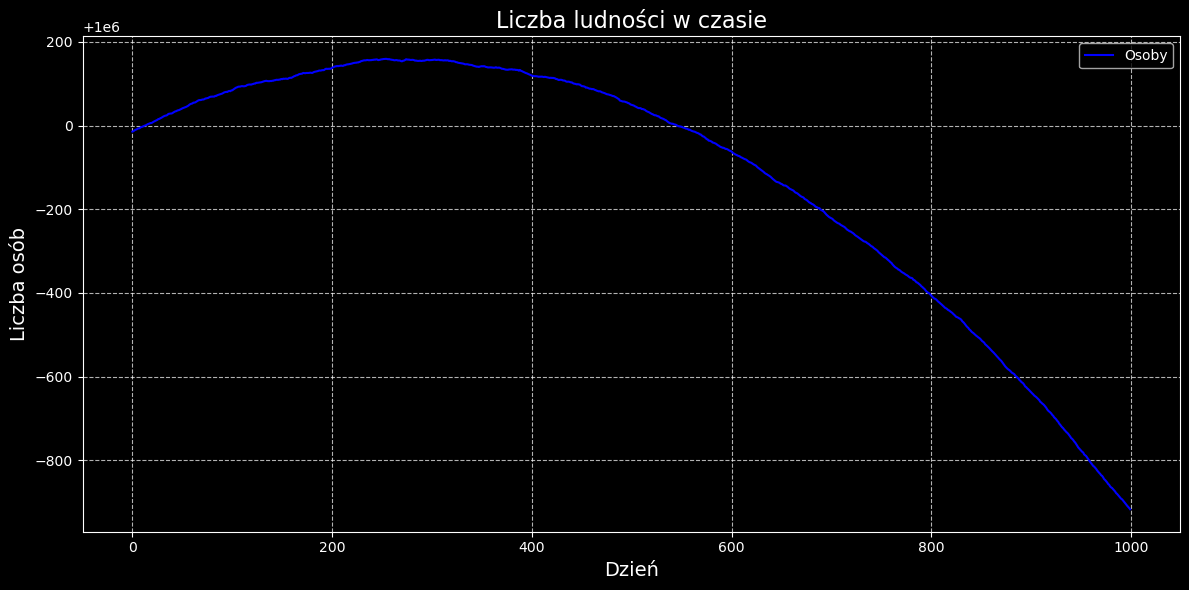

In [156]:
# wizualizacja (liczba ludności)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(zdrowi_k_stany_baza_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, zdrowi_k_stany_baza_mean + zdrowi_m_stany_baza_mean, label='Osoby', color='blue')

# Dodanie tytułu i podpisów osi
plt.title('Liczba ludności w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

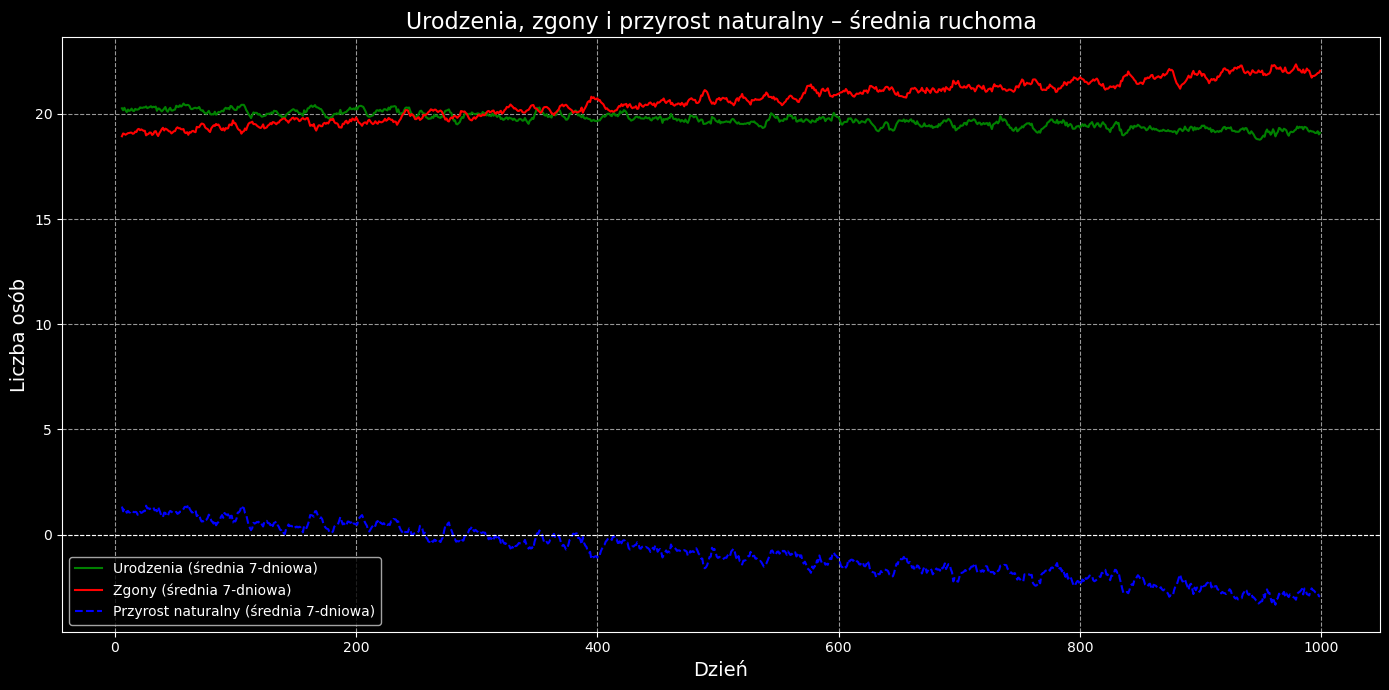

In [158]:
# wizualizacja (urodzenia i zgony)
import numpy as np

# Funkcja pomocnicza do liczenia średniej ruchomej
def srednia_ruchoma(dane, okno=7):
    return np.convolve(dane, np.ones(okno)/okno, mode='valid')

# Zakładamy, że dane są listami lub numpy array
dni = list(range(len(urodzeni_k_stany_baza_mean)))

# Sumy dzienne
urodzenia = [k + m for k, m in zip(urodzeni_k_stany_baza_mean, urodzeni_m_stany_baza_mean)]
zgony = [k + m for k, m in zip(zmarli_ogolem_k_stany_baza_mean, zmarli_ogolem_m_stany_baza_mean)]
przyrost = [u - z for u, z in zip(urodzenia, zgony)]

# Średnie ruchome (np. 7 dni)
okno = 7
urodzenia_avg = srednia_ruchoma(urodzenia, okno)
zgony_avg = srednia_ruchoma(zgony, okno)
przyrost_avg = srednia_ruchoma(przyrost, okno)

# Odpowiednio skrócony wektor dni
dni_avg = dni[okno - 1:]  # ponieważ średnia jest przesunięta

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
plt.plot(dni_avg, urodzenia_avg, label='Urodzenia (średnia 7-dniowa)', color='green')
plt.plot(dni_avg, zgony_avg, label='Zgony (średnia 7-dniowa)', color='red')
plt.plot(dni_avg, przyrost_avg, label='Przyrost naturalny (średnia 7-dniowa)', color='blue', linestyle='--')

# Linia zera dla przyrostu
plt.axhline(0, color='white', linewidth=0.8, linestyle='--')

# Tytuł i podpisy
plt.title('Urodzenia, zgony i przyrost naturalny – średnia ruchoma', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka i legenda
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

#### Scenariusz z chorobą

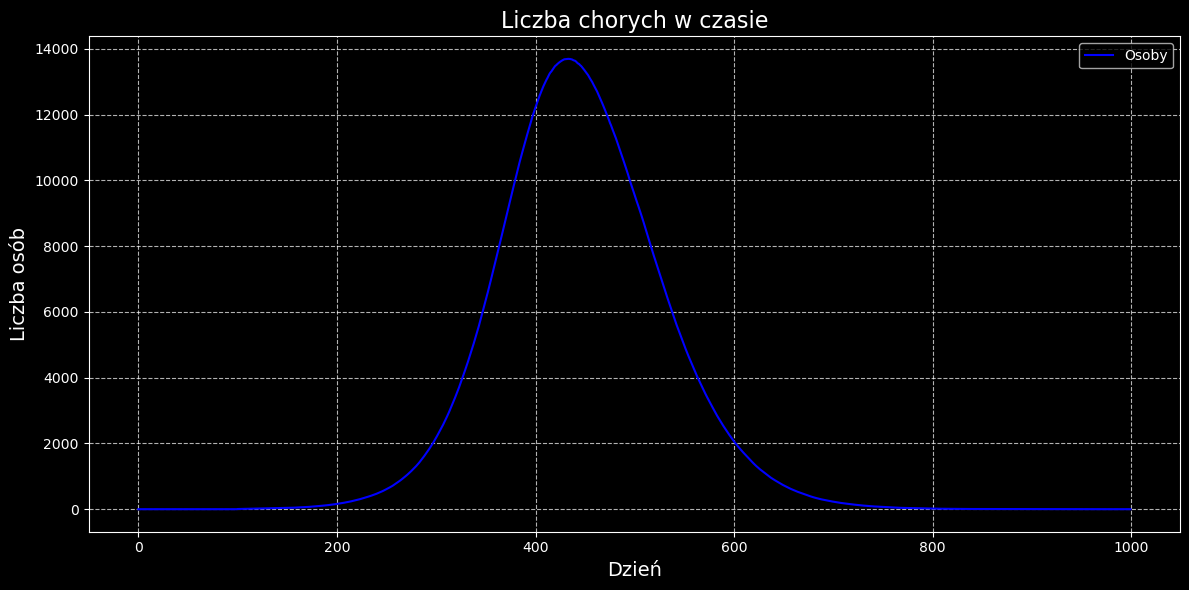

In [177]:
# wizualizacja (liczba chorych)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(chorzy_k_stany_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (chorzy_k_stany_mean + chorzy_m_stany_mean + ponownie_chorzy_k_stany_mean + ponownie_chorzy_m_stany_mean), label='Osoby', color='blue')

# Dodanie tytułu i podpisów osi
plt.title('Liczba chorych w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

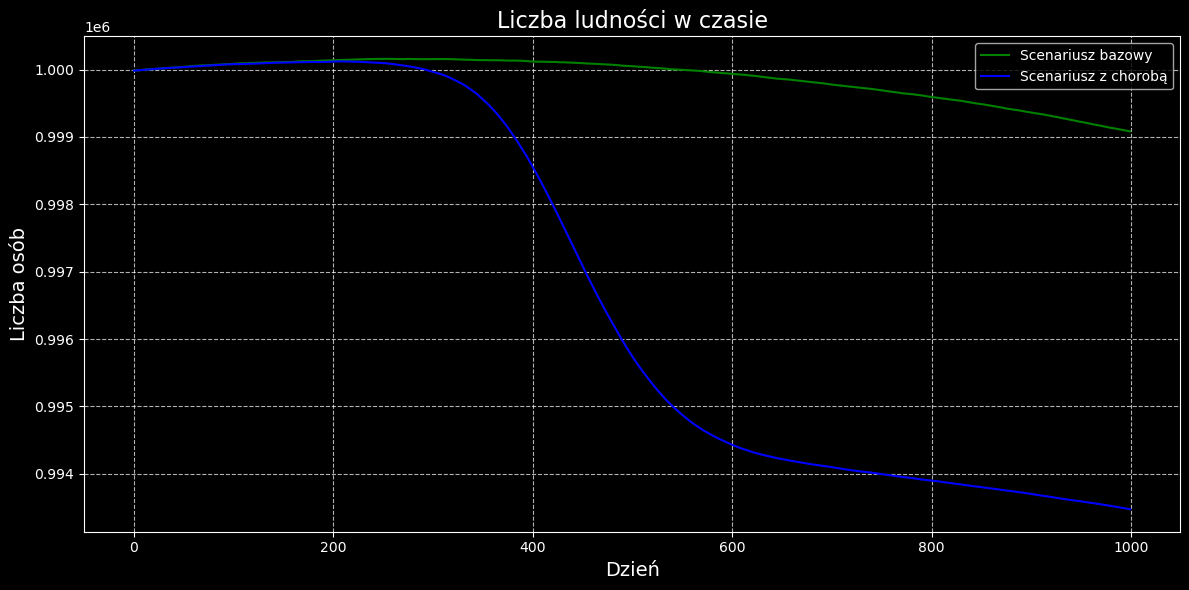

In [183]:
# wizualizacja (liczba ludności)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(zdrowi_k_stany_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (zdrowi_k_stany_baza_mean + zdrowi_m_stany_baza_mean), label='Scenariusz bazowy', color='green')
plt.plot(dni, (zdrowi_k_stany_mean + zdrowi_m_stany_mean + ozdrowiali_k_stany_mean + ozdrowiali_m_stany_mean + chorzy_k_stany_mean + chorzy_m_stany_mean + ponownie_chorzy_k_stany_mean + ponownie_chorzy_m_stany_mean), label='Scenariusz z chorobą', color='blue')

# Dodanie tytułu i podpisów osi
plt.title('Liczba ludności w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend(loc="best")

# Pokaż wykres
plt.tight_layout()
plt.show()

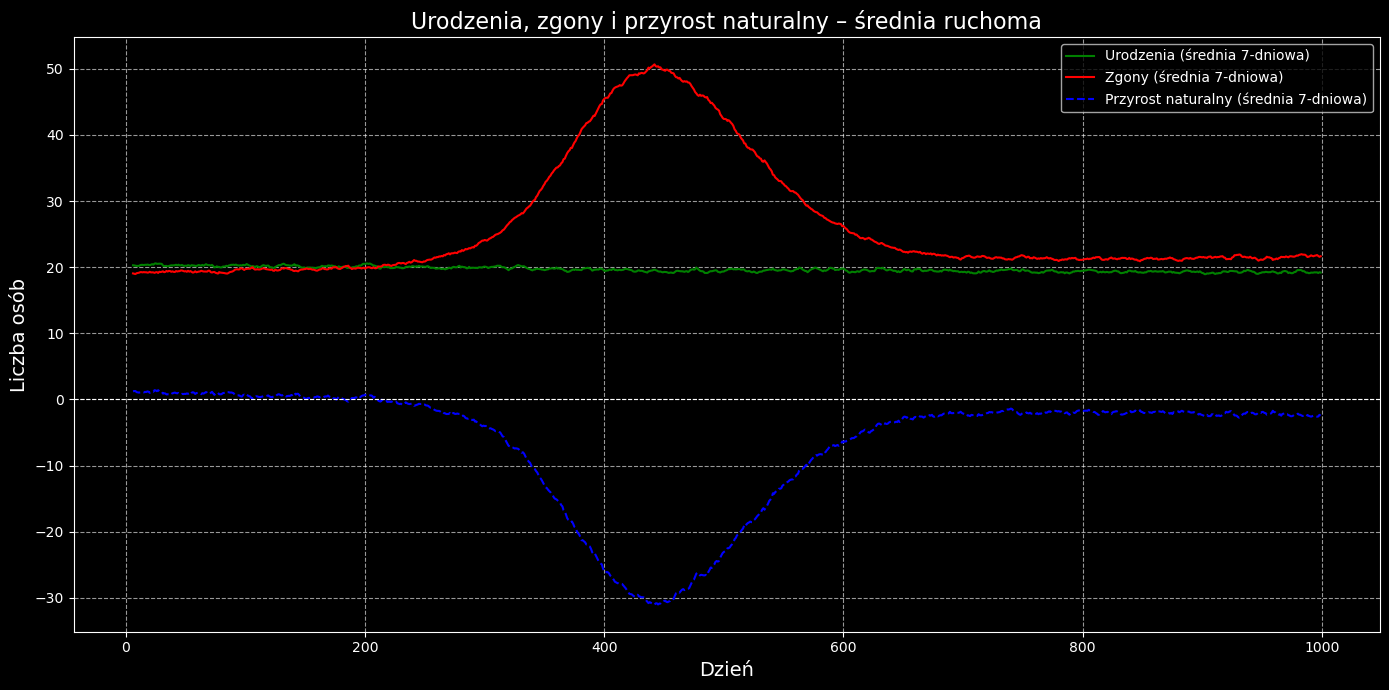

In [185]:
# wizualizacja (urodzenia i zgony)
import numpy as np

# Funkcja pomocnicza do liczenia średniej ruchomej
def srednia_ruchoma(dane, okno=7):
    return np.convolve(dane, np.ones(okno)/okno, mode='valid')

# Zakładamy, że dane są listami lub numpy array
dni = list(range(len(urodzeni_k_stany_mean)))

# Sumy dzienne
urodzenia = [k + m for k, m in zip(urodzeni_k_stany_mean, urodzeni_m_stany_mean)]
zgony = [k + m for k, m in zip(zmarli_ogolem_k_stany_mean, zmarli_ogolem_m_stany_mean)]
przyrost = [u - z for u, z in zip(urodzenia, zgony)]

# Średnie ruchome (np. 7 dni)
okno = 7
urodzenia_avg = srednia_ruchoma(urodzenia, okno)
zgony_avg = srednia_ruchoma(zgony, okno)
przyrost_avg = srednia_ruchoma(przyrost, okno)

# Odpowiednio skrócony wektor dni
dni_avg = dni[okno - 1:]  # ponieważ średnia jest przesunięta

# Tworzenie wykresu
plt.figure(figsize=(14, 7))
plt.plot(dni_avg, urodzenia_avg, label='Urodzenia (średnia 7-dniowa)', color='green')
plt.plot(dni_avg, zgony_avg, label='Zgony (średnia 7-dniowa)', color='red')
plt.plot(dni_avg, przyrost_avg, label='Przyrost naturalny (średnia 7-dniowa)', color='blue', linestyle='--')

# Linia zera dla przyrostu
plt.axhline(0, color='white', linewidth=0.8, linestyle='--')

# Tytuł i podpisy
plt.title('Urodzenia, zgony i przyrost naturalny – średnia ruchoma', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka i legenda
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

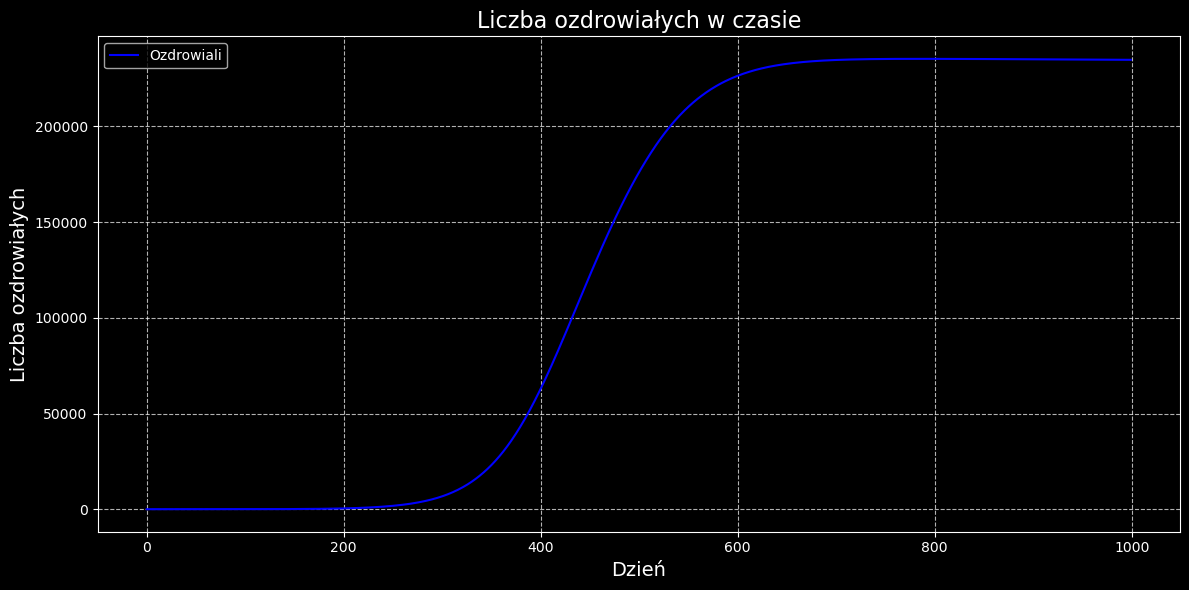

In [189]:
# wizualizacja (liczba ozdrowiałych z choroby)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(ozdrowiali_k_stany_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (ozdrowiali_k_stany_mean + ozdrowiali_m_stany_mean), label='Ozdrowiali', color='blue')

# Dodanie tytułu i podpisów osi
plt.title('Liczba ozdrowiałych w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba ozdrowiałych', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

#### Scenariusz z chorobą i szczepionką

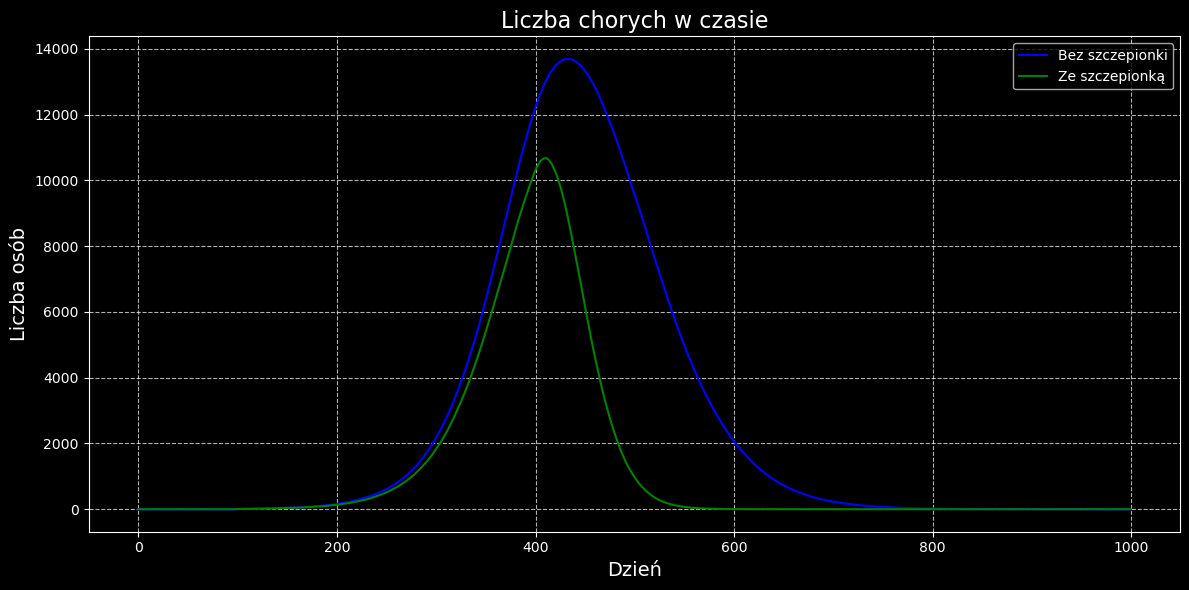

In [191]:
# wizualizacja (liczba chorych)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(chorzy_k_stany_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (chorzy_k_stany_mean + chorzy_m_stany_mean + ponownie_chorzy_k_stany_mean + ponownie_chorzy_m_stany_mean), label='Bez szczepionki', color='blue')
plt.plot(dni, (chorzy_k_stany_2_mean + chorzy_m_stany_2_mean + ponownie_chorzy_k_stany_2_mean + ponownie_chorzy_m_stany_2_mean), label='Ze szczepionką', color='green')

# Dodanie tytułu i podpisów osi
plt.title('Liczba chorych w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

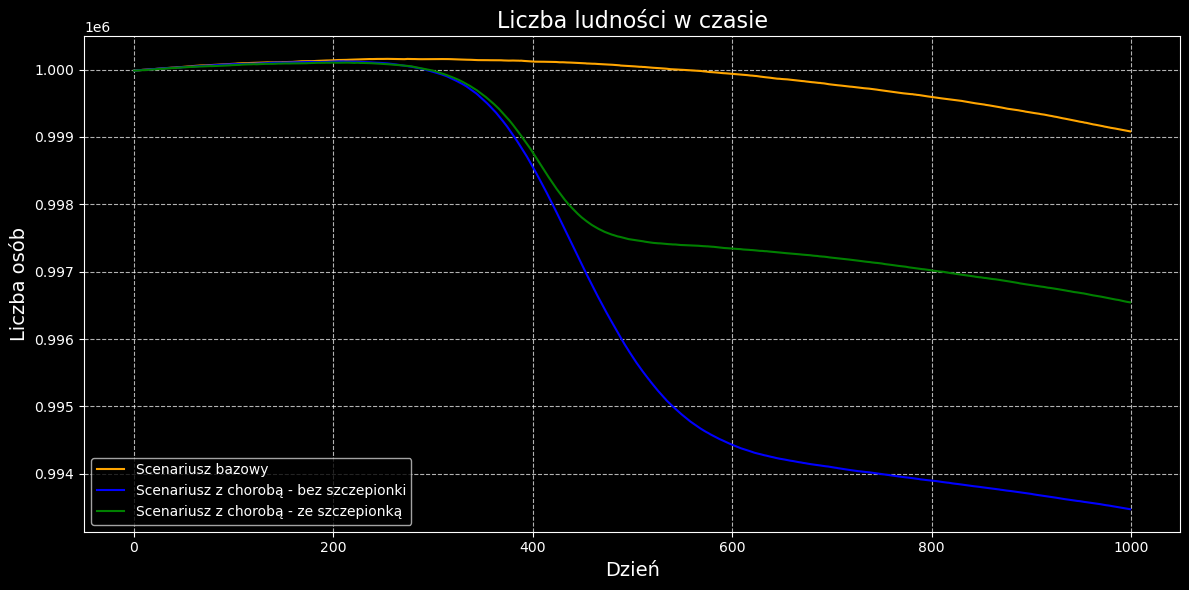

In [195]:
# wizualizacja (liczba żyjących)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(zdrowi_k_stany_baza_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (zdrowi_k_stany_baza_mean + zdrowi_m_stany_baza_mean), label='Scenariusz bazowy', color='orange')
plt.plot(dni, (zdrowi_k_stany_mean + zdrowi_m_stany_mean + ozdrowiali_k_stany_mean + ozdrowiali_m_stany_mean + chorzy_k_stany_mean + chorzy_m_stany_mean + ponownie_chorzy_k_stany_mean + ponownie_chorzy_m_stany_mean), label='Scenariusz z chorobą - bez szczepionki', color='blue')
plt.plot(dni, (zdrowi_k_stany_2_mean + zdrowi_m_stany_2_mean + ozdrowiali_k_stany_2_mean + ozdrowiali_m_stany_2_mean + chorzy_k_stany_2_mean + chorzy_m_stany_2_mean + ponownie_chorzy_k_stany_2_mean + ponownie_chorzy_m_stany_2_mean + zaszczepieni_k_stany_mean + zaszczepieni_m_stany_mean), label='Scenariusz z chorobą - ze szczepionką', color='green')

# Dodanie tytułu i podpisów osi
plt.title('Liczba ludności w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

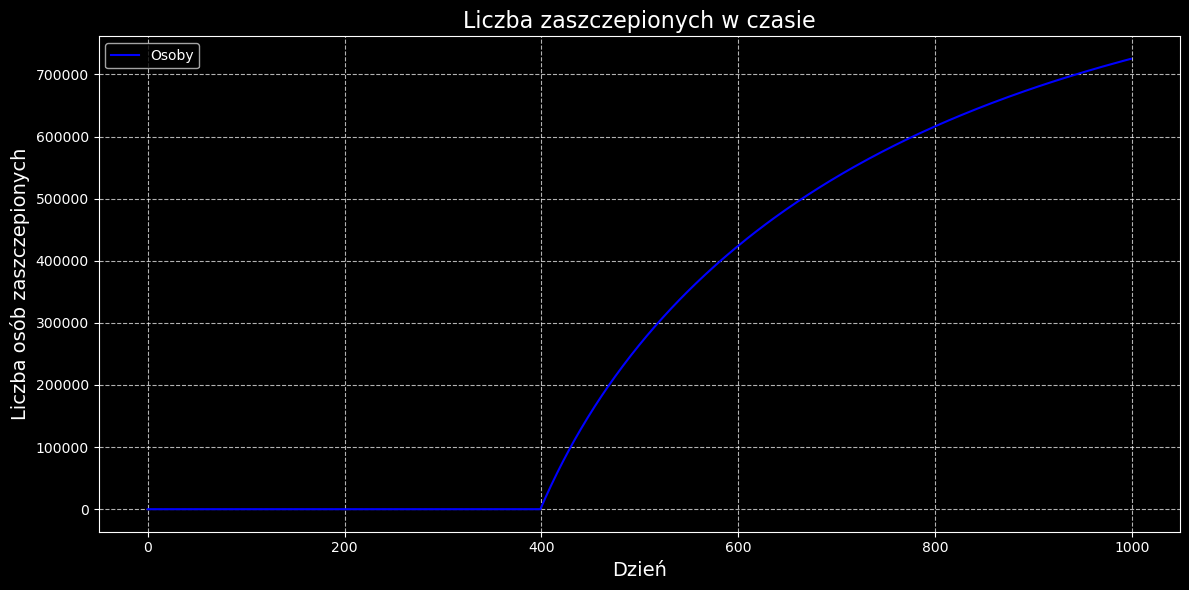

In [201]:
# wizualizacja (liczba zaszczepionych)

# Tworzymy wektor dni (od 0 do 364)
dni = list(range(len(zaszczepieni_k_stany_mean)))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.plot(dni, (zaszczepieni_k_stany_mean + zaszczepieni_m_stany_mean), label='Osoby', color='blue')

# Dodanie tytułu i podpisów osi
plt.title('Liczba zaszczepionych w czasie', fontsize=16)
plt.xlabel('Dzień', fontsize=14)
plt.ylabel('Liczba osób zaszczepionych', fontsize=14)

# Siatka pomocnicza
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda
plt.legend()

# Pokaż wykres
plt.tight_layout()
plt.show()

## Zapisywanie symulacji do plików .csv

In [203]:
# Scenariusz bazowy
df_output = pd.DataFrame({
    "dzien symulacji": [i+1 for i in range(len(zdrowi_k_stany_baza_mean))],
    "liczba kobiet": zdrowi_k_stany_baza_mean,
    "liczba mezczyzn": zdrowi_m_stany_baza_mean,
    "urodzone kobiety": urodzeni_k_stany_baza_mean,
    "urodzeni mezczyzni": urodzeni_m_stany_baza_mean,
    "zmarle kobiety": zmarli_ogolem_k_stany_baza_mean,
    "zmarli mezczyzni": zmarli_ogolem_m_stany_baza_mean
})

# Zapis do pliku CSV
df_output.to_csv("base.csv", index=False, encoding='utf-8')

In [205]:
# Scenariusz z chorobą
df_output = pd.DataFrame({
    "dzien symulacji": [i+1 for i in range(len(zdrowi_k_stany_mean))],
    "liczba kobiet przed choroba": zdrowi_k_stany_mean,
    "liczba mezczyzn przed choroba": zdrowi_m_stany_mean,
    "urodzone kobiety": urodzeni_k_stany_mean,
    "urodzeni mezczyzni": urodzeni_m_stany_mean,
    "zmarle kobiety": zmarli_ogolem_k_stany_mean,
    "zmarli mezczyzni": zmarli_ogolem_m_stany_mean,
    "liczba chorych kobiet": chorzy_k_stany_mean,
    "liczba chorych mezczyzn": chorzy_m_stany_mean,
    "liczba kobiet po chorobie": ozdrowiali_k_stany_mean,
    "liczba mezczyzn po chorobie": ozdrowiali_m_stany_mean,
    "liczba ponownie chorych kobiet": ponownie_chorzy_k_stany_mean,
    "liczba ponownie chorych mezczyzn": ponownie_chorzy_m_stany_mean,
    "kobiety zmarle z powodu choroby": zmarli_choroba_k_stany_mean,
    "mezczyzni zmarli z powodu choroby": zmarli_choroba_m_stany_mean,
})

# Zapis do pliku CSV
df_output.to_csv("disease.csv", index=False, encoding='utf-8')

In [207]:
# Scenariusz z chorobą i szczepionką
df_output = pd.DataFrame({
    "dzien symulacji": [i+1 for i in range(len(zdrowi_k_stan))],
    "liczba kobiet przed choroba": zdrowi_k_stany_2_mean,
    "liczba mezczyzn przed choroba": zdrowi_m_stany_2_mean,
    "urodzone kobiety": urodzeni_k_stany_2_mean,
    "urodzeni mezczyzni": urodzeni_m_stany_2_mean,
    "zmarle kobiety": zmarli_ogolem_k_stany_2_mean,
    "zmarli mezczyzni": zmarli_ogolem_m_stany_2_mean,
    "liczba chorych kobiet": chorzy_k_stany_2_mean,
    "liczba chorych mezczyzn": chorzy_m_stany_2_mean,
    "liczba kobiet po chorobie": ozdrowiali_k_stany_2_mean,
    "liczba mezczyzn po chorobie": ozdrowiali_m_stany_2_mean,
    "liczba ponownie chorych kobiet": ponownie_chorzy_k_stany_2_mean,
    "liczba ponownie chorych mezczyzn": ponownie_chorzy_m_stany_2_mean,
    "kobiety zmarle z powodu choroby": zmarli_choroba_k_stany_2_mean,
    "mezczyzni zmarli z powodu choroby": zmarli_choroba_m_stany_2_mean,
    "liczba zaszczepionych kobiet": zaszczepieni_k_stany_mean,
    "liczba zaszczepionych mezczyzn": zaszczepieni_m_stany_mean,
})

# Zapis do pliku CSV
df_output.to_csv("vaccine.csv", index=False, encoding='utf-8')